# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [ ]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=1890756181d01893c2bdb6a6ae4adb51080c510afda8f53c20fa22705ecd5136
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [ ]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [ ]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [ ]:
# 1.4)
import google.colab
from google.colab import files

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [ ]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/',
                                       download = True,
                                       train = True,
                                       transform = transform)
test_set_orig = datasets.FashionMNIST('MNIST_data/',
                                       download = True,
                                       train = False,
                                       transform = transform)

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 6.97MB/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 58.3MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.5MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



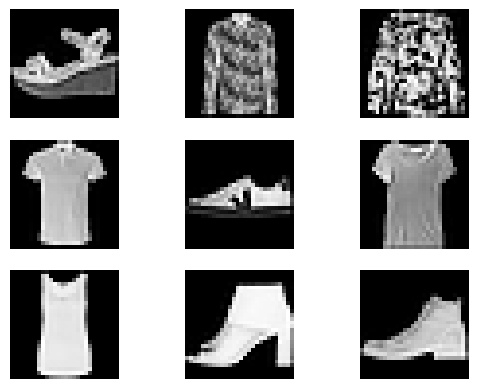

In [ ]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [ ]:
class CustomDataset(Dataset):
    """
    Clase personalizada derivada de torch.utils.data.Dataset para transformar el
    dataset FashionMNIST a un formato pensado para entrenar un autoencoder.

    En lugar de retornar (imagen, etiqueta), retorna (imagen, imagen).
    """
    def __init__(self, dataset: Dataset):
        """
        Constructor de la clase CustomDataset.

        Parámetros:
        - dataset (Dataset): Dataset base (por ejemplo, FashionMNIST) que se va a transformar.
        """
        self.dataset = dataset

    def __len__(self) -> int:
        """
        Retorna la cantidad de muestras en el dataset.

        Retorno:
        - int: Longitud del dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Retorna la i-ésima muestra del dataset como un par (input, output),
        donde ambos son iguales a la i-ésima imagen.

        Parámetros:
        - index (int): Índice de la muestra.

        Retorno:
        - tuple[torch.Tensor, torch.Tensor]: Par (imagen, imagen).
        """
        image, _ = self.dataset[index]  # Ignorar el label original
        return image, image

# Transformar a datasets para autoencoder usando CustomDataset
train_set_autoencoder = CustomDataset(train_set_orig)
test_set_autoencoder = CustomDataset(test_set_orig)

In [ ]:
# Ejemplo de uso
image, output = train_set_autoencoder[0]
print("Shape de la imagen (input):", image.shape)
print("Shape de la salida (output):", output.shape)
print("Son iguales input y output?", torch.equal(image, output))


Shape de la imagen (input): torch.Size([1, 28, 28])
Shape de la salida (output): torch.Size([1, 28, 28])
Son iguales input y output? True


## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoenconder convolucional* constituida por las siguientes capas:

1. Una capa convolucional 2D constituida por:

* Una capa `Conv2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que deberá mapear $1$ canal de entradas de dimensiones $(28,28)$ a $16$ canales de de salida de dimensiones $(26,26)$. Para ello utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
* Una capa `ReLU`.
* Una capa `Dropout`.
* Una capa `MaxPool` (ver https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) con un kernel de dimensiones $(2,2)$, de manera que mapeará entradas de dimensiones $(26,26)$ a salidas de dimensiones $(13,13)$.

2. Una capa lineal constituida por:

* Una capa `Flatten` que mapea una entrada de $16$ canales de dimensiones $(13,13)$ a un vector de dimensión $16\times 13\times 13$.
* Una capa `Linear` que mapea un vector de dimensión $16\times 13\times 13$ a un vector de dimensión $n$.
* Una capa `ReLU`.
* Una capa `Dropout`.

3. Una capa capa convolucional 2D transpuesta, constituida por:

* una capa `ConvTranspose2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Para ello, utilice un kernel de dimensiones $(6,6)$ y un stride de dimensiones $(2,2)$, dejando el resto de los parámetros en sus valores por defecto, i.e. padding de $(1,1)$ y out_padding de $(0,0)$.

* Una capa `Sigmoid`.

**3)** Grafique, a modo de comparación, unas pocas imagenes a predecir vs las correspondientes imagenes predichas utilizando el modelo sin entrenar y dropout $p=0.2$.

In [ ]:
class Autoencoder(nn.Module):
    """
    Combina el encoder, el linear_layer y el decoder en una sola red neuronal.
    """
    def __init__(self, n: int, p: float):
        """
        Constructor de la clase Autoencoder.

        Parámetros:
        - n (int): Número de neuronas en la capa lineal intermedia.
        """
        super(Autoencoder, self).__init__()
        # Codificador (Encoder)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),  # Conv2d: (1, 28, 28) -> (16, 26, 26)
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.MaxPool2d(kernel_size=2)  # MaxPool2d: (16, 26, 26) -> (16, 13, 13)
        )

        # Calcula el tamaño después del encoder
        self.encoder_output_shape = 16*13*13

        # Capas lineales con tamaño n
        self.linear_layer = nn.Sequential(
            nn.Flatten(),  # Aplana la entrada
            nn.Linear(self.encoder_output_shape, n),  # Reduce al tamaño n
            nn.ReLU(),                                #PREGUNTARRRRRRRR!!!!!
            nn.Dropout(p=p),                          #PREGUNTARRRRRRRR!!!!!
            nn.Linear(n, self.encoder_output_shape),  # Reconstruye al tamaño original
            nn.ReLU()
        )

        # Decodificador (Decoder)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=16,
                out_channels=1,
                kernel_size=6,
                stride=2,
                padding=1,
                output_padding=0
            ),  # ConvTranspose2d: (16, 13, 13) -> (1, 28, 28)
            nn.Sigmoid()  # Limita la salida al rango [0, 1]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define el flujo de datos a través de la red.

        Parámetros:
        - x (torch.Tensor): Tensor de entrada con forma (batch_size, 1, 28, 28).

        Retorno:
        - torch.Tensor: Tensor de salida con forma (batch_size, 1, 28, 28).
        """
        # Paso por el encoder
        encoded = self.encoder(x)

        # Paso por la capa lineal
        linear_output = self.linear_layer(encoded)

        # Reconstrucción: adaptamos el tensor para el decoder
        batch_size = x.size(0)
        decoded_input = linear_output.view(batch_size, 16, 13, 13)  # Volvemos al tamaño esperado por el decoder

        # Paso por el decoder
        decoded = self.decoder(decoded_input)
        return decoded


In [ ]:
# Crear el modelo
n = 16*13*13
model = Autoencoder(n=n, p=0.2)

# Crear un tensor de prueba (batch_size=4, canales=1, altura=28, ancho=28)
input_tensor = torch.rand(4, 1, 28, 28)

# Pasar el tensor por la red
output_tensor = model(input_tensor)

print("Forma de la salida:", train_set_autoencoder[0][0].shape)


Forma de la salida: torch.Size([1, 28, 28])


torch.Size([1, 28, 28])


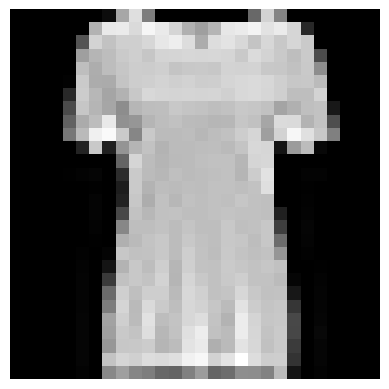

In [ ]:
figure = plt.figure()

image = train_set_orig[10][0]
plt.axis("off")
plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

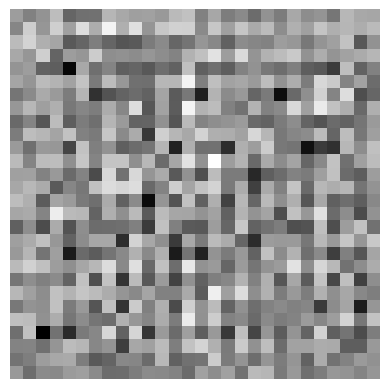

In [ ]:
figure = plt.figure()

image = train_set_orig[10][0]
image_with_channel = image.unsqueeze(0)
output_tensor = model(image_with_channel)

output_image = output_tensor.detach().squeeze(0)

# Visualizar la imagen con imshow
plt.axis("off")
plt.imshow(output_image[0], cmap="Greys_r")  # Selecciona el canal 0 (ya que tiene forma (1, 28, 28))
plt.show()

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [ ]:
# 5.1)